In [1]:
import warnings
warnings.simplefilter('ignore', FutureWarning)
import pandas as pd
import numpy as np
import operator
from keras.preprocessing.image import load_img
from keras.preprocessing.image import img_to_array
from mrcnn.config import Config
from mrcnn.model import MaskRCNN
from mrcnn.visualize import display_instances
from PIL import Image, ImageDraw
from itertools import combinations

Using TensorFlow backend.


In [2]:
# define the test configuration
class TestConfig(Config):
    NAME = "test"
    GPU_COUNT = 1
    IMAGES_PER_GPU = 1
    NUM_CLASSES = 1 + 80

In [3]:
# define the model
rcnn = MaskRCNN(mode='inference', model_dir='./', config=TestConfig())

# load coco model weights
rcnn.load_weights('mask_rcnn_coco.h5', by_name=True)

Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where
Instructions for updating:
box_ind is deprecated, use box_indices instead


In [4]:
class_names = ['BG', 'person', 'bicycle', 'car', 'motorcycle', 'airplane',
               'bus', 'train', 'truck', 'boat', 'traffic light',
               'fire hydrant', 'stop sign', 'parking meter', 'bench', 'bird',
               'cat', 'dog', 'horse', 'sheep', 'cow', 'elephant', 'bear',
               'zebra', 'giraffe', 'backpack', 'umbrella', 'handbag', 'tie',
               'suitcase', 'frisbee', 'skis', 'snowboard', 'sports ball',
               'kite', 'baseball bat', 'baseball glove', 'skateboard',
               'surfboard', 'tennis racket', 'bottle', 'wine glass', 'cup',
               'fork', 'knife', 'spoon', 'bowl', 'banana', 'apple',
               'sandwich', 'orange', 'broccoli', 'carrot', 'hot dog', 'pizza',
               'donut', 'cake', 'chair', 'couch', 'potted plant', 'bed',
               'dining table', 'toilet', 'tv', 'laptop', 'mouse', 'remote',
               'keyboard', 'cell phone', 'microwave', 'oven', 'toaster',
               'sink', 'refrigerator', 'book', 'clock', 'vase', 'scissors',
               'teddy bear', 'hair drier', 'toothbrush']

In [5]:
class_dimensions = {'BG':[1,1,1], 'person':[1.7,0.4,0.3], 'bicycle':[0.8,1.7,0.3], 'car':[1.5,4.8,1.9], 'motorcycle':[0.9,2.1,0.5],
               'airplane':[11.3,36.6,28.3],'bus':[3.1,12.2,2.6], 'train':[4.6,17.1,3.4], 'truck':[4.1,22.0,2.6], 'boat':[1.5,4.9,1.9], 'traffic light':[0.8,0.24,0.15],
               'fire hydrant':[0.73,0.25,0.25], 'stop sign':[0.76,0.76,0.002], 'parking meter':[1.2,0.2,0.15], 'bench':[0.9,1.8,0.61], 'bird':[0.25,0.15,0.15],
               'cat':[0.25,0.51,0.2], 'dog':[0.64,0.91,0.38], 'horse':[1.7,2.4,0.91], 'sheep':[1.17,1.27,0.58], 'cow':[1.7,2.45,0.82], 'elephant':[3.2,4.0,2], 'bear':[1.5,3.0,1.0],
               'zebra':[1.6,2.0,0.5], 'giraffe':[5.8,2.4,0.6], 'backpack':[0.43,0.23,0.15], 'umbrella':[0.7,1.0,0.05], 'handbag':[0.18,0.25,0.09], 'tie':[0.51,0.07,0.001],
               'suitcase':[0.76,0.53,0.30], 'frisbee':[0.28,0.28,0.025], 'skis':[1.7,0.1,0.025], 'snowboard':[1.57,0.25,0.025], 'sports ball':[0.24,0.24,0.24],
               'kite':[1.27,1.52,0.002], 'baseball bat':[0.81,0.064,0.064], 'baseball glove':[0.31,0.31,0.13], 'skateboard':[0.79,0.2,0.003],
               'surfboard':[2.13,0.53,0.076], 'tennis racket':[0.71,0.25,0.25], 'bottle':[0.18,0.018,0.018], 'wine glass':[0.15,0.05,0.05], 'cup':[0.12,0.092,0.092],
               'fork':[0.15,0.025,0.002], 'knife':[0.23,0.02,0.002], 'spoon':[0.14,0.025,0.002], 'bowl':[0.13,0.27,0.27], 'banana':[0.18,0.038,0.038], 'apple':[0.076,0.076,0.076],
               'sandwich':[0.13,0.064,0.03], 'orange':[0.076,0.076,0.076], 'broccoli':[0.03,0.03,0.03], 'carrot':[0.18,0.025,0.025], 'hot dog':[0.18,0.03,0.03], 'pizza':[0.31,0.31,0.002],
               'donut':[0.076,0.076,0.051], 'cake':[0.25,0.25,0.12], 'chair':[0.83,0.51,0.51], 'couch':[0.71,2.34,0.76], 'potted plant':[0.38,0.14,0.14], 'bed':[0.98,2.25,1.73],
               'dining table':[0.74,2.4,1.0], 'toilet':[0.72,0.72,0.49], 'tv':[0.83,1.5,0.05], 'laptop':[0.2,0.28,0.02], 'mouse':[0.02,0.11,0.05], 'remote':[0.1,0.05,0.025],
               'keyboard':[0.30,0.12,0.01], 'cell phone':[0.14,0.071,0.005], 'microwave':[0.25,0.46,0.36], 'oven':[1.2,0.76,0.76], 'toaster':[0.19,0.27,0.16],
               'sink':[0.53,0.56,0.18], 'refrigerator':[1.78,0.91,0.91], 'book':[0.25,0.15,0.03], 'clock':[0.31,0.31,0.05], 'vase':[0.20,0.1,0.1], 'scissors':[0.20,0.05,0.002],
               'teddy bear':[0.38,0.19,0.1], 'hair dryer':[0.25,0.22,0.076], 'toothbrush':[0.18,0.013,0.013]}

In [6]:
from collections import Counter
class_ratios = dict(Counter({key:np.prod(class_dimensions[key])/np.prod(class_dimensions['person']) for (key, value) in class_dimensions.items()}).most_common())
class_ratios

{'airplane': 57374.088235294126,
 'train': 1310.9999999999998,
 'truck': 1149.6078431372548,
 'bus': 482.01960784313724,
 'elephant': 125.49019607843137,
 'boat': 68.45588235294117,
 'car': 67.05882352941175,
 'giraffe': 40.94117647058823,
 'bear': 22.058823529411764,
 'bed': 18.69926470588235,
 'horse': 18.2,
 'cow': 16.741666666666664,
 'dining table': 8.705882352941176,
 'zebra': 7.8431372549019605,
 'refrigerator': 7.22557843137255,
 'couch': 6.189529411764704,
 'BG': 4.901960784313725,
 'bench': 4.844117647058823,
 'motorcycle': 4.63235294117647,
 'sheep': 4.224617647058823,
 'oven': 3.397647058823529,
 'bicycle': 2.0,
 'toilet': 1.245176470588235,
 'dog': 1.0848627450980393,
 'chair': 1.05825,
 'person': 1.0,
 'suitcase': 0.5923529411764705,
 'surfboard': 0.4205705882352941,
 'tv': 0.3051470588235294,
 'sink': 0.26188235294117646,
 'fire hydrant': 0.2236519607843137,
 'tennis racket': 0.21752450980392155,
 'microwave': 0.2029411764705882,
 'parking meter': 0.1764705882352941,
 'u

In [7]:
class ObjectMapping:
    '''
        Required:
        import pandas as pd
        import numpy as np
        import operator
        from keras.preprocessing.image import load_img
        from keras.preprocessing.image import img_to_array
        from mrcnn.config import Config
        from mrcnn.model import MaskRCNN
        from mrcnn.visualize import display_instances
        from PIL import Image, ImageDraw
        from itertools import combinations
    ''' 
    
    def __init__ (self, filename, results, class_names):
        self.filename = filename
        self.r = results                    # results contain rois, class_ids, masks, and scores
        self.class_names = class_names
        self.img_height = self.r['masks'].shape[0]
        self.img_width = self.r['masks'].shape[1]
        self.total_objects = len(self.r['rois'])
        self.imgH_center_range = [0.333*self.img_height, 0.667*self.img_height]
        self.imgW_center_range = [0.4*self.img_width, 0.6*self.img_width]
    
    def get_box(self, object_id):
        object_id = object_id-1
        h1 = self.r['rois'][object_id][0]
        h2 = self.r['rois'][object_id][2]
        w1 = self.r['rois'][object_id][1]
        w2 = self.r['rois'][object_id][3]
        return (h1, w1, h2, w2)
    
    def get_objectID(self):
        return {index:self.class_names[self.r['class_ids'][index-1]] for index, array in enumerate(self.r['rois'], start=1)}
    
    def object_class(self, object_id):
        object_id = object_id-1
        return self.class_names[self.r['class_ids'][object_id]]
    
    def count_objects(self):
        "summarize type of objects detected with count"
        objects = [self.class_names[index] for index in self.r['class_ids']]
        objects = dict(zip(*np.unique(objects, return_counts=True)))
        return objects
    
    def get_mask(self, object_id):
        object_id = object_id-1
        return self.r['masks'][:,:,object_id]
    
    def _merge_masks(self, *args):
        """Internal. Merge mask boolean arrays"""
        mask = self._false_canvas()
        for ids in args:
            if(isinstance(ids, np.ndarray)):
                mask = mask | ids.copy()
            else:    
                mask = mask | self.get_mask(ids).copy()
        return mask
    
    def _show_massbox(self, *args, size=2):
        mass_boxes = self._false_canvas()
        """Internal. Only for displaying mass boxes for masks that have an object ID"""
        for ids in args:
            h1, w1, h2, w2 = self.mass_box(ids)
            mass_boxes[h1:h2, w1:w2] = True
            mass_boxes[h1+size:h2-size, w1+size:w2-size] = False
        print('endshowmassbox')
        return mass_boxes
    
    def show_mask(self, *args, show_massbox = False):
        """Creates PIL image from a matrix of booleans. Shows a mask that is either
           directly passed as a boolean matrix or that is retrieved using the object ID.
           Mass box is only for a mask that is retrieved with the object ID."""
        mask = self._merge_masks(*args)
        if show_massbox:
            mass_boxes = self._show_massbox(*args)
            mask = mask | mass_boxes
        mask_size = mask.shape[::-1]
        maskbytes = np.packbits(mask, axis=1)
        return Image.frombytes(mode='1', size=mask_size, data=maskbytes)
           
    def box_center(self, object_id):
        h1, w1, h2, w2 = self.get_box(object_id)
        hbb_center = int((h1+h2)/2)
        wbb_center = int((w1+w2)/2)
        return (hbb_center, wbb_center)

    def mask_pixel_count(self, object_id):
        h1, w1, h2, w2 = self.get_box(object_id)
        mask = self.get_mask(object_id)
        return (np.sum(mask[h1:h2, w1:w2]))
    
    def mask_pixel_count(self, object_id, h1, w1, h2, w2):
        mask = self.get_mask(object_id)
        return (np.sum(mask[h1:h2, w1:w2]))
    
    def _best_coord(self, object_id, current_coords, step_coord, add=True):
        """Internal only. As edges of the bounding box are scanned in one at a time,
           this returns the coordinate that maximizes number of mask pixels multiplied 
           by the percentage of mask pixels remaining in the moving bounding box."""
        step=1
        step_variable = current_coords[step_coord]
        h1, w1, h2, w2 = current_coords
        bmask = self.get_mask(object_id)
        true_count = np.sum(bmask[h1:h2, w1:w2])
        bmask_area = bmask.shape[0]*bmask.shape[1]
        
        check_max = (true_count/bmask_area)*true_count # Track largest product of perc and count
        temp_area = bmask_area                         # Initialize to any value. Shrinks as step_variable changes
        while(temp_area != 0):
            if(add):
                step_variable = step_variable + step
            else:
                step_variable = step_variable - step
                
            box_adj = {0:bmask[step_variable:h2, w1:w2],
                       1:bmask[h1:h2, step_variable:w2],
                       2:bmask[h1:step_variable, w1:w2],
                       3:bmask[h1:h2, w1:step_variable]}
            
            temp_mask = box_adj[step_coord]
            temp_true = np.sum(temp_mask)
            temp_area = temp_mask.shape[0]*temp_mask.shape[1]
            if (temp_area != 0):
                temp_perc = temp_true/temp_area
            if (temp_true*temp_perc > check_max):
                best_step_variable = step_variable
                check_max = temp_true*temp_perc       
        return best_step_variable
    
    def mass_box(self, object_id):
        """Adjustment to bounding box to reflect a better center of mass"""
        h1, w1, h2, w2 = self.get_box(object_id)
        w1_best = self._best_coord(object_id, (h1, w1, h2, w2), 1, add=True)
        w2_best = self._best_coord(object_id, (h1, w1_best, h2, w2), 3, add=False)
        h2_best = self._best_coord(object_id, (h1, w1_best, h2, w2_best), 2, add=False)
        h1_best = self._best_coord(object_id, (h1, w1_best, h2_best, w2_best), 0, add=True)
                             
        return(h1_best, w1_best, h2_best, w2_best)
                                
    def mass_center(self, object_id):
        h1, w1, h2, w2 = self.mass_box(object_id)
        hm_center = int((h1+h2)/2)
        wm_center = int((w1+w2)/2)
        return (hm_center, wm_center)
    
    def object_location(self, object_id):
        # section canvas into horizontal and vertical thirds
        htop = (0, 0, int(self.imgH_center_range[0]), self.img_width)
        hcenter = (int(self.imgH_center_range[0]), 0, int(self.imgH_center_range[1]), self.img_width)
        hbottom = (int(self.imgH_center_range[1]), 0, self.img_height, self.img_width)
        wleft = (0, 0, self.img_height, int(self.imgW_center_range[0]))
        wcenter = (0, int(self.imgW_center_range[0]), self.img_height, int(self.imgW_center_range[1]))
        wright = (0, int(self.imgW_center_range[1]), self.img_height, self.img_width)
        
        # count the number of pixels in each section
        htop_pixels = self.mask_pixel_count(object_id, *htop)
        hcenter_pixels = self.mask_pixel_count(object_id, *hcenter)
        hbottom_pixels = self.mask_pixel_count(object_id, *hbottom)
        wleft_pixels = self.mask_pixel_count(object_id, *wleft)
        wcenter_pixels = self.mask_pixel_count(object_id, *wcenter)
        wright_pixels = self.mask_pixel_count(object_id, *wright)
        
        hloc_dict = {'top':htop_pixels, 'center':hcenter_pixels, 'bottom':hbottom_pixels}
        wloc_dict = {'left':wleft_pixels, 'center':wcenter_pixels, 'right':wright_pixels}
        
        # return the key with the largest value in each dictionary
        hloc = max(hloc_dict.items(), key=operator.itemgetter(1))[0]
        wloc = max(wloc_dict.items(), key=operator.itemgetter(1))[0]
        return (hloc, wloc)
    
    def _edge_pixels(self, object_id, h1, w1, h2, w2, return_true = True):
        """Internal. Returns list of pixels at the edge border of a mask.
           return_true determines if the list is the coords True or False pixels at border."""
        if(isinstance(object_id, np.ndarray)):
            mask = object_id
        else:
            mask = self.get_mask(object_id)
        edge_pixels = []
        # Scan horizontally to find edge
        for i in range(h1,h2):    
            for j in range(w1,w2):
                if((mask[i, j] != mask[i, j+1]) and (mask[i,j] == False)):
                    if return_true:
                        edge_pixels.append((i,j+1))
                    else:
                        edge_pixels.append((i,j))
                        
                if((mask[i, j] != mask[i, j+1]) and (mask[i,j] == True)):
                    if return_true:
                        edge_pixels.append((i,j))
                    else:
                        edge_pixels.append((i,j+1))

        # Scan vertically to find edge
        for j in range(w1,w2):
            for i in range(h1,h2):
                if((mask[i, j] != mask[i+1, j]) and (mask[i, j] == False)):
                    if return_true:
                        edge_pixels.append((i+1,j))
                    else:
                        edge_pixels.append((i,j))
                if((mask[i, j] != mask[i+1, j]) and (mask[i, j] == True)):
                    if return_true:
                        edge_pixels.append((i,j))
                    else:
                        edge_pixels.append((i+1,j))
        return edge_pixels
    
    def inflate_mask(self, object_id, inflation_factor=1):
        h1, w1, h2, w2 = self.get_box(object_id)
        # Inflate box holding the mask but don't extend beyond boundaries of image
        if (h1-inflation_factor >= 0):
            h1 = h1-inflation_factor
        if (w1-inflation_factor >= 0):
            w1 = w1-inflation_factor
        if (h2+inflation_factor <= self.img_height):
            h2 = h2 + inflation_factor
        if (w2+inflation_factor <= self.img_width):
            w2 = w2 + inflation_factor
            
        mask = self.get_mask(object_id).copy()      
        for expand in range(inflation_factor):
            edge_pixels = self._edge_pixels(mask, h1, w1, h2, w2, return_true=False)
            for coords in edge_pixels:
                i, j = coords
                mask[i,j] = True
        return mask
    
    def _false_canvas(self):
        """Internal"""
        return np.full((self.img_height, self.img_width), False, dtype=bool)
    
    def create_box_mask(self, h1, w1, h2, w2):
        false_canvas = self._false_canvas()
        false_canvas[h1:h2, w1:w2] = True
        return false_canvas
    
    def object_outline(self, *args, pad=2):
        """Returns a boolean array of the object outline. Must use show_mask() to view"""
        outline = self._false_canvas()
        for obj in args:
            h1, w1, h2, w2 = self.get_box(obj)
            # Pad but don't extend beyond boundaries of image
            if (h1-pad >= 0):
                h1 = h1-pad
            if (w1-pad >= 0):
                w1 = w1-pad
            if (h2+pad <= self.img_height):
                h2 = h2 + pad
            if (w2+pad <= self.img_width):
                w2 = w2 + pad

            edge_pixels = self._edge_pixels(obj, h1, w1, h2, w2, return_true=True)
            for coords in edge_pixels:
                i,j = coords
                outline[i,j] = True
        return outline
        
    def object_topline(self, *args, pad=2):
        """Returns a boolean array of the object topline. Must use show_mask() to view"""
        topline = self._false_canvas()
        for obj in args:
            h1, w1, h2, w2 = self.get_box(obj)
            # Pad but don't extend beyond boundaries of image
            if (h1-pad >= 0):
                h1 = h1-pad
            if (w1-pad >= 0):
                w1 = w1-pad
            if (h2+pad <= self.img_height):
                h2 = h2 + pad
            if (w2+pad <= self.img_width):
                w2 = w2 + pad

            mask = self.get_mask(obj)
            top_pixels = []
            for j in range(w1,w2):
                for i in range(h1,h2):
                    if((mask[i, j] != mask[i+1, j]) and (mask[i, j] == False)):
                            top_pixels.append((i+1,j))
            for coords in top_pixels:
                i,j = coords
                topline[i,j] = True
        return topline
        
    def object_relations(self, tol=0.1):
        if(self.total_objects <= 1):
            print('Not enough object detected.')
        else:
            ids = range(1, self.total_objects+1)
            combos = combinations(ids, r=2) # all possible combinations of pairs
            object_relations = {'object relations': {'next to':[], 'above':[], 'below':[],
                                                     'touching':[], 'on':[], 'in':[]}
                               }
            for rel in combos:
                print(f"Analyzing object_id {rel[0]}: {self.object_class(rel[0])} "
                      f"and object_id {rel[1]}: {self.object_class(rel[1])}")
                obja, objb = rel
                flip = rel[::-1]
                h1a, w1a, h2a, w2a = self.get_box(obja)
                h1b, w1b, h2b, w2b = self.get_box(objb)
                # Widen width of box size by tol
                if(w1a-tol*w1a >= 0):
                    w1a = int(w1a-tol*w1a)
                if(w2a+tol*w2a <= self.img_width):
                    w2a = int(w2a+tol*w2a)
                if(w1b-tol*w1b >= 0):
                    w1b = int(w1b-tol*w1b)
                if(w2a+tol*w2a <= self.img_width):
                    w2b = int(w2b+tol*w2b)
  
                maska = self.get_mask(obja).copy()
                maskb = self.get_mask(objb).copy()
                boxa = self.create_box_mask(h1a, w1a, h2a, w2a)
                boxb = self.create_box_mask(h1b, w1b, h2b, w2b)
                h1ma, w1ma, h2ma, w2ma = self.mass_box(obja)
                h1mb, w1mb, h2mb, w2mb = self.mass_box(objb)
                hcentera, wcentera = self.mass_center(obja)
                hcenterb, wcenterb = self.mass_center(objb)
                
                # check interaction
                touching = np.any(self.inflate_mask(obja) & self.inflate_mask(objb))
                a_in_b = set(range(h1ma, h2ma)).issubset(set(range(h1mb, h2mb))) and set(range(w1ma, w2ma)).issubset(set(range(w1mb, w2mb)))
                b_in_a = set(range(h1mb, h2mb)).issubset(set(range(h1ma, h2ma))) and set(range(w1mb, w2mb)).issubset(set(range(w1ma, w2ma)))
                a_on_b = (hcentera < hcenterb) and not(set(range(h1ma, h2ma)).issubset(set(range(h1mb, h2mb))) and set(range(w1ma, w2ma)).issubset(set(range(w1mb, w2mb))))
                b_on_a = (hcenterb < hcentera) and not(set(range(h1mb, h2mb)).issubset(set(range(h1ma, h2ma))) and set(range(w1mb, w2mb)).issubset(set(range(w1ma, w2ma))))
                
                if(touching):
                    object_relations['object relations']['touching'].append(rel)
                    if(a_in_b):
                        object_relations['object relations']['in'].append(rel)
                    if(b_in_a):
                        object_relations['object relations']['in'].append(flip)
                    if(a_on_b):
                        object_relations['object relations']['on'].append(rel)
                        object_relations['object relations']['above'].append(rel)
                        object_relations['object relations']['below'].append(flip)
                    if(b_on_a):
                        object_relations['object relations']['on'].append(flip)
                        object_relations['object relations']['above'].append(flip)
                        object_relations['object relations']['below'].append(rel)                  
                
                # check next to
                elif(np.any(maska & boxb) or np.any(maskb & boxa)):
                    object_relations['object relations']['next to'].append(rel)
                          
        return object_relations
    
    
        
       
        
    
#     def object_summary(self, object_id):
    
#     def summary(self):
        
        
    

        
        

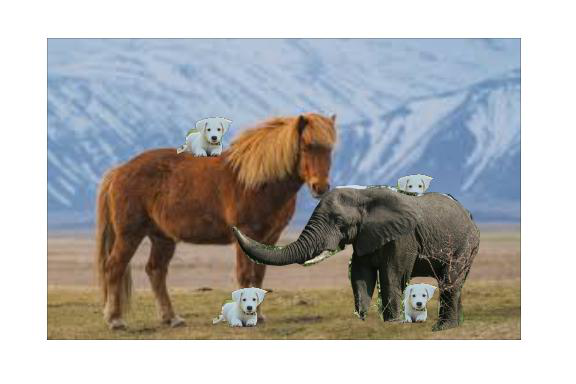

In [8]:
#load image
imagefile = 'images/animals_test_mixed_hidden-5.jpg'
img = load_img(imagefile)
img

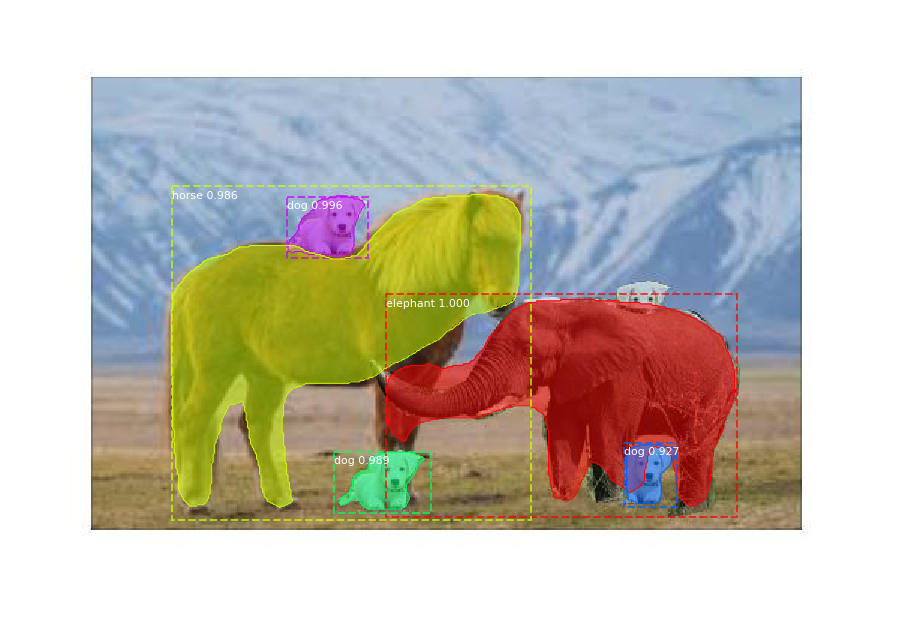

In [9]:
img = img_to_array(img)
# make prediction
results = rcnn.detect([img], verbose=False)
# get dictionary for first prediction
r = results[0]

# instantiate object
x = ObjectMapping(imagefile, r, class_names)
display_instances(img, r['rois'], r['masks'], r['class_ids'], class_names, r['scores'])

# Start Testing

In [ ]:
ids = x.get_objectID()
ids

In [ ]:
x.object_class(5)

In [ ]:
len(ids)

In [ ]:
x.count_objects()

In [ ]:
%%time
x.object_relations()

In [ ]:
x.mass_center(1)

In [ ]:
x.mass_center(5)

In [ ]:
#pass object id
x.show_mask(1,2)

In [ ]:
x.get_box(1)

In [ ]:
mb = x.mass_box(1)
mb

In [ ]:
x.show_mask(1,2,3,4,5, show_massbox=True)

In [ ]:
bm = x.create_box_mask(200, 250, 300, 350)
x.show_mask(bm)

In [ ]:
ele = x.get_mask(1)
interaction = ele & bm
x.show_mask(interaction)

In [ ]:
np.any(interaction)

In [ ]:
x.show_mask(ele, bm)

In [ ]:
x.img_height

In [ ]:
x.img_width

In [ ]:
infm = x.inflate_mask(2, inflation_factor=1)
x.show_mask(infm)

In [ ]:
infm = x.inflate_mask(2, inflation_factor=20)
x.show_mask(infm)

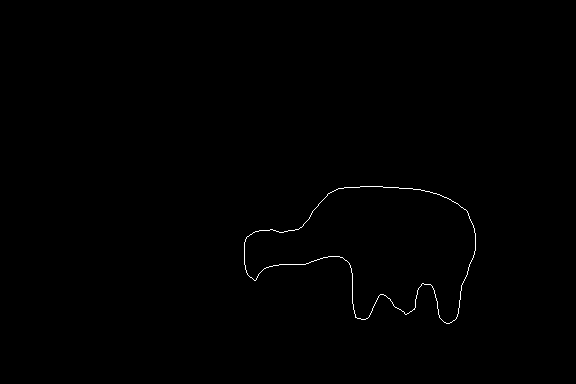

In [10]:
outline1 = x.object_outline(1)
x.show_mask(outline1)

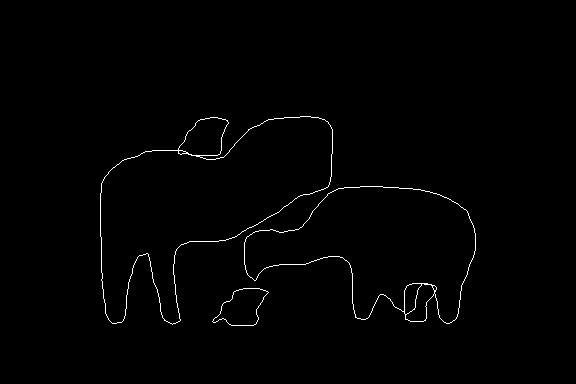

In [11]:
outline1 = x.object_outline(1,2,3,4,5)
x.show_mask(outline1)

In [ ]:
#pass_object_id
x.object_location(1)

In [ ]:
topline = x.object_topline(1,2)
x.show_mask(topline)

In [ ]:
#load image
img = load_img('images/mix_dog-cat-bird.jpg')
img

In [ ]:
img = img_to_array(img)
# make prediction
results = rcnn.detect([img], verbose=False)
# get dictionary for first prediction
r = results[0]

# instantiate object
x = ObjectMapping('images/mix_dog-cat-bird.jpg', r, class_names)
display_instances(img, r['rois'], r['masks'], r['class_ids'], class_names, r['scores'])

In [ ]:
x.object_ids

In [ ]:
x.objects_detected()

In [ ]:
x.show_mask(7)

In [ ]:
x.object_location(7)

In [ ]:
x.r['rois'][6]

In [ ]:
list(x.object_ids.keys())

In [ ]:
def get_relations():
    object_ids = [i-1 for i in list(x.object_ids.keys())]
    bb = []
    for obj in object_ids:
        bb.append(r['rois'][obj])
    return bb

In [ ]:
get_relations()

In [ ]:
from itertools import combinations
def get_relations():
    object_ids = [i-1 for i in list(x.object_ids.keys())]
    bb = []
    for obj in object_ids:
        bb.append(r['rois'][obj])
    bb_exp = [(i[0], int(i[1]-.25*i[1]), i[2], int(i[3]+.25*i[3])) for i in bb]
    w_range = []
    h_range = []
    for obj in bb_exp:
        h1, w1, h2, w2 = obj
        w_range.append(list(range(w1, w2)))
        h_range.append(list(range(h1, h2)))
    return (h_range, w_range) 

In [ ]:
h, w = get_relations()

# Groundtruth Data

In [ ]:
!ls /media/jartav/df64012a-b10a-47ca-9611-0c39359831b6

In [ ]:
import os

In [ ]:
# airplane_files = os.listdir('/media/jartav/df64012a-b10a-47ca-9611-0c39359831b6/passenger_jet_groundtruth')
# truck_files = os.listdir('/media/jartav/df64012a-b10a-47ca-9611-0c39359831b6/semi_truck_groundtruth')
# car_files = os.listdir('/media/jartav/df64012a-b10a-47ca-9611-0c39359831b6/cars_groundtruth')
# person_files = os.listdir('/media/jartav/df64012a-b10a-47ca-9611-0c39359831b6/person_groundtruth')
# dog_files = os.listdir('/media/jartav/df64012a-b10a-47ca-9611-0c39359831b6/german_shepherd_groundtruth')

# airplane_filepath = '/media/jartav/df64012a-b10a-47ca-9611-0c39359831b6/passenger_jet_groundtruth'
# truck_filepath = '/media/jartav/df64012a-b10a-47ca-9611-0c39359831b6/semi_truck_groundtruth'
# car_filepath = '/media/jartav/df64012a-b10a-47ca-9611-0c39359831b6/cars_groundtruth'
# person_filepath = '/media/jartav/df64012a-b10a-47ca-9611-0c39359831b6/person_groundtruth'
# dog_filepath = '/media/jartav/df64012a-b10a-47ca-9611-0c39359831b6/german_shepherd_groundtruth'

# filepath_dict = {'airplane':airplane_filepath, 'truck':truck_filepath, 'car':car_filepath,
#                   'person':person_filepath, 'dog':dog_filepath}

# folders_dict = {'airplane':airplane_files, 'truck':truck_files, 'car':car_files, 'person':person_files,
#                 'dog':dog_files}

In [ ]:
# %%time
# perc_dict = {'airplane':[], 'truck':[], 'car':[], 'person':[], 'dog':[]}
# for file_object, directory in folders_dict.items():
#     for file in directory:
#         #load image
#         img = load_img(filepath_dict[file_object] + '/' + file)
#         img = img_to_array(img)
#         # make prediction
#         results = rcnn.detect([img], verbose=False)
#         # get dictionary for first prediction
#         r = results[0]
#         # instantiate object
#         x = ObjectMapping(file, r, class_names)
#         if (len(x.object_ids) == 1 and x.object_ids[1] == file_object):
#             perc_pixel = x.mask_pixel_count(1, 0,0, x.img_height, x.img_width)/(x.img_height*x.img_width)
#             perc_dict[file_object].append(perc_pixel)   

In [ ]:
# import pickle
# with open('perc_dict.pkl', 'wb') as f:   
#         pickle.dump(perc_dict, f)

In [ ]:
with open('perc_dict.pkl', 'rb') as f:
    perc_dict = pickle.load(f)

In [ ]:
perc_dict_summary = {'object':[], 'mean':[], 'median':[], 'stddev':[], 'min':[], 'max':[], 'range':[]}
for k, v in perc_dict.items():
    perc_dict_summary['object'].append(k)
    perc_dict_summary['mean'].append(np.mean(v))
    perc_dict_summary['median'].append(np.median(v))
    perc_dict_summary['stddev'].append(np.std(v))
    perc_dict_summary['min'].append(np.min(v))
    perc_dict_summary['max'].append(np.max(v))
    perc_dict_summary['range'].append(np.max(v)-np.min(v))
    

In [ ]:
df_gt = pd.DataFrame(perc_dict_summary)

In [ ]:
df_gt

In [ ]:
df_gt.loc[df_gt['object']=='airplane','mean']

In [ ]:
any(item in (1,2,3) for item in (3,4,5))

In [ ]:
from itertools import combinations
list(combinations(list(x.object_ids.keys()), r=2))

In [ ]:
aaa = np.ones(9)
aaa = np.array([bool(i) for i in aaa]).reshape(3, 3)
aaa

In [ ]:
aaa[1,2]

In [ ]:
bbb = ~aaa.copy()
bbb

In [ ]:
aaa | bbb

In [ ]:
ccc = np.array([[True, False, True], [False, True, False],[True, False, True]])
ccc

In [ ]:
bbb & ccc

In [ ]:
np.zeros((4,3), dtype=bool)

In [ ]:
def test2(matrix):
    return matrix

In [ ]:
test2(aaa)

In [ ]:
type(bbb)

In [ ]:
type(testmask) == 'numpy.ndarray'

In [ ]:
isinstance(testmask, np.ndarray)

In [ ]:
aaa

In [ ]:
aaa[0:3, 1:2] = False

In [ ]:
aaa

In [ ]:
zzz = np.full((1,5), False, dtype=bool).flatten()
zzz

In [ ]:
zzz[-1] = True

In [ ]:
zzz

In [ ]:
zzz[0:2]=True

In [ ]:
zzz

In [ ]:
yyy = np.array([True, False])
zzz = np.array([True, False])

In [ ]:
np.all(yyy==zzz)

In [ ]:
zzz = np.array([[1,2,3,'a','b'], [4,5,6,'d','e'], [7,8,9,'f','g'], [10, 11, 12, 'h', 'i']])
zzz

In [ ]:
hstep = 0
vstep = 0
wnd = zzz[0:1,]
wnd

In [ ]:
wnd[0+vstep:1+vstep, 0+hstep:2+hstep].reshape(1,2)

In [ ]:
np.flip(wnd)

In [ ]:
yyy = np.array([1,2,3,4,5])
yyy

In [ ]:
yyy[::-1]

In [ ]:
np.flip(yyy)

In [ ]:
aaa = np.array([1,2,3,4,5,6,7,8])
aaa

In [ ]:
for i in range(len(aaa)+1):
    print(i)

In [ ]:
bbb = np.array([10, 20, 30, 40, 50, 60, 70 , 80])
bbb

In [ ]:
aaa[0:3] = bbb[0:3]

In [ ]:
aaa

In [ ]:
bbb = np.array([True, True, True, False, False, True, False])
bbb

In [ ]:
np.flip(bbb)

In [ ]:
c1 =100
c2 = 200

In [ ]:
for i in reversed(range(c1,c2+1)):
    print(i)

In [ ]:
np.full((1,1), False, dtype=bool)

In [ ]:
match_pattern = np.full((1, 3+1), False, dtype=bool)
match_pattern[:,-1] = True
match_pattern

In [ ]:
match_pattern.shape

In [ ]:
match_pattern[:] = True
match_pattern

In [ ]:
for i in range(1):
    print(i)

In [ ]:
from itertools import combinations
aaa = [1,2,3,4,5]
combos = combinations(aaa, r=2)
for i in combos:
    print(i)

In [ ]:
ids = range(1, 6)
combos = combinations(ids, r=2)
for i in combos:
    print(i)

In [ ]:
yyy = {'yyy': {'a':[], 'b':[]}}
yyy

In [ ]:
yyy['yyy']

In [ ]:
yyy['yyy']['a']

In [ ]:
yyy

In [ ]:
def test(*args):
    for ids in args:
        print(ids)

test(1, 2, 3)

In [ ]:
zzz = (1,2)
zzz

In [ ]:
zzz[::-1]

In [ ]:
all(x in (1,2) for x in (1,2,3))

In [ ]:
set(range(1,5)).issubset(set(range(1,10))) and\
set(range(1,10)).issubset(set(range(1,20)))

In [ ]:
range(1,3)

In [ ]:
all(x in range(1,5) for x in range(1,3))

In [ ]:
3 > 2

In [ ]:
range(1,5) not in range(1,10)

In [ ]:
[1,5] in [1,5,10]

In [ ]:
1 in range(1,5)

In [ ]:
(1,2,3) not in (1,2,3)

In [ ]:
range(1,5) in range(1,10)

In [ ]:
not(set(range(1,5)).issubset(set(range(1,10))) and\
set(range(1,10)).issubset(set(range(1,20))))

In [ ]:
def test(x):
    if(x>0):
        print('positive')
    if(x>5):
        print('bigger than 5')
    elif(x>10):
        print('bigger than 10')

In [ ]:
test(11)

In [ ]:
pattern = np.array([False, True]).reshape(1,2)
pattern

In [ ]:
np.flip(pattern)

In [ ]:
aaa=np.array([[False, True, False], [True, True, True], [False, False, False]])
aaa

In [ ]:
aaa[1, 1:3]

In [ ]:
aaa[0:2, 1]

In [ ]:
aaa[1, 1:3].shape